In [2]:

%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

bucket = 'filonowy-bucket'

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

CPU times: user 891 ms, sys: 148 ms, total: 1.04 s
Wall time: 11.1 s


In [3]:
import os 
import urllib.request
import boto3

s3_train_key = "kwiatki/train"
s3_validation_key = "kwiatki/validation"
s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)


In [4]:
num_layers = "18" 
image_shape = "3,224,224"
num_training_samples = "952"
num_classes = "17"
mini_batch_size =  "64"
epochs = "2"
learning_rate = "0.01"

In [5]:
s3_validation

's3://filonowy-bucket/kwiatki/validation/'

In [6]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3') 
job_name_prefix = 'kwiatki-imageclassification'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },

    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: kwiatki-imageclassification-2020-01-16-15-17-27

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://filonowy-bucket/kwiatki/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 47.2 ms, sys: 7.86 ms, total: 55 ms
Wall time: 144 ms


In [7]:
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)


status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [8]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


In [9]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="kwiatki-image-classification-model-" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime()) 
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

kwiatki-image-classification-model--2020-01-16-15-23-41
s3://filonowy-bucket/kwiatki-imageclassification/output/kwiatki-imageclassification-2020-01-16-15-17-27/output/model.tar.gz
arn:aws:sagemaker:us-east-2:587501239756:model/kwiatki-image-classification-model--2020-01-16-15-23-41
CPU times: user 62.3 ms, sys: 16.7 ms, total: 78.9 ms
Wall time: 320 ms


In [33]:
model_name

'kwiatki-image-classification-model--2020-01-16-15-23-41'

In [10]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'AcceleratorType': 'ml.eia1.large',
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: kwiatki-imageclassification-epc--2020-01-16-15-23-45
Endpoint configuration arn:  arn:aws:sagemaker:us-east-2:587501239756:endpoint-config/kwiatki-imageclassification-epc--2020-01-16-15-23-45


In [11]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: kwiatki-imageclassification-ep--2020-01-16-15-23-48
EndpointArn = arn:aws:sagemaker:us-east-2:587501239756:endpoint/kwiatki-imageclassification-ep--2020-01-16-15-23-48
CPU times: user 13.5 ms, sys: 160 µs, total: 13.7 ms
Wall time: 161 ms


In [12]:

response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [13]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker')

--2020-01-16 15:45:46--  https://filonowy-bucket.s3.us-east-2.amazonaws.com/tmp/63.jpg
Resolving filonowy-bucket.s3.us-east-2.amazonaws.com (filonowy-bucket.s3.us-east-2.amazonaws.com)... 52.219.100.168
Connecting to filonowy-bucket.s3.us-east-2.amazonaws.com (filonowy-bucket.s3.us-east-2.amazonaws.com)|52.219.100.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28635 (28K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  27.96K  --.-KB/s    in 0.001s  

2020-01-16 15:45:46 (39.5 MB/s) - ‘/tmp/test.jpg’ saved [28635/28635]



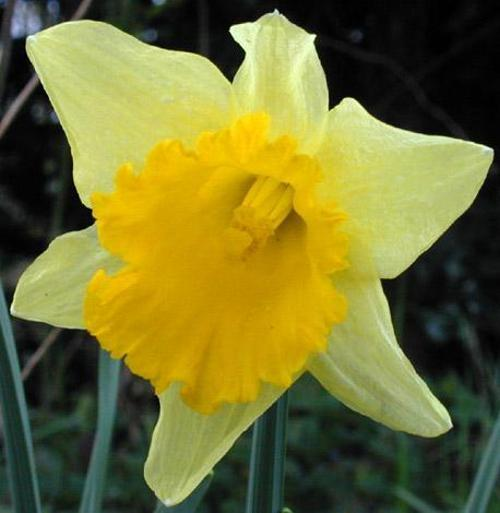

In [31]:
!wget -O /tmp/test.jpg https://filonowy-bucket.s3.us-east-2.amazonaws.com/tmp/63.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)

In [32]:

%%time
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
result = json.loads(result)
index = np.argmax(result)
print("index: " + str(index))
print(result)

index: 5
[0.06014932692050934, 0.0665552169084549, 0.05537455156445503, 0.045315857976675034, 0.027942752465605736, 0.22998666763305664, 0.03538835793733597, 0.007202617358416319, 0.03076907992362976, 0.12259788811206818, 0.06684515625238419, 0.016736026853322983, 0.017690515145659447, 0.030131837353110313, 0.1683921068906784, 0.012819275259971619, 0.006102763582020998]
CPU times: user 12.8 ms, sys: 3.5 ms, total: 16.3 ms
Wall time: 112 ms


In [34]:
endpoint_name


'kwiatki-imageclassification-ep--2020-01-16-15-23-48'

In [35]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '85248cd1-ed4a-429a-8b0a-93c57f65830d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '85248cd1-ed4a-429a-8b0a-93c57f65830d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 16 Jan 2020 15:57:31 GMT'},
  'RetryAttempts': 0}}